In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional
import tqdm

# env and agent

In [62]:
@dataclass
class Bandit():
    mean: float
    var: float
    seed: Optional[int] = None

    def __post_init__(self):
        self.rng = np.random.default_rng(self.seed)
    
    def pull(self):
        return self.rng.normal(self.mean, self.var)
    
class BanditProblem():
    def __init__(self, k: int, starting_mean = 0, starting_var = 1, seed = None):
        self.rng = np.random.default_rng(seed)
        self.bandit_means = self.rng.normal(starting_mean, starting_var, k)
        self.bandits = [Bandit(bandit_mean, starting_var) for bandit_mean in self.bandit_means]

    def pull(self, bandit_idx):
        return self.bandits[bandit_idx].pull()

    def get_optimal_bandit(self):
        return np.argmax([bandit.mean for bandit in self.bandits])
    
    def update_bandit_means(self, ):
        self.bandit_means += self.rng.normal(0, 0.01, len(self.bandit_means))
        for i, bandit in enumerate(self.bandits):
            bandit.mean = self.bandit_means[i]
        

class BanditAgent():
    def __init__(self, k: int, epsilon: float = 0.1, alpha: float = None, seed=None):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = np.zeros(k)
        self.n = np.zeros(k)
        self.rng = np.random.default_rng(seed)

    def choose_action(self):
        if self.rng.random() < self.epsilon:
            return self.rng.integers(0, self.k)
        else:
            return np.argmax(self.q)

    def update(self, action, reward):
        self.n[action] += 1
        if self.alpha is None: # Sample-average method
            self.q[action] += (reward - self.q[action]) / self.n[action]
        else: # Constant step-size method
            self.q[action] += self.alpha * (reward - self.q[action])

In [59]:
def perform_strategy(bandit_pairs, update = False):
    for pair_id, pair in bandit_pairs.items():
        bandit_problem = pair['bandit_problem']
        bandit_agent = pair['bandit_agent']

        action = bandit_agent.choose_action()
        reward = bandit_problem.pull(action)

        bandit_agent.update(action, reward)
        
        pair['actions'].append(action)
        pair['rewards'].append(reward)
        pair['optimal_choice'].append(action == bandit_problem.get_optimal_bandit())
        if update:
            bandit_problem.update_bandit_means()

def get_averages(bandit_pairs):
    avg_rewards = np.array([pair['rewards'] for pair in bandit_pairs.values()])
    avg_rewards = np.mean(avg_rewards, axis=0)

    avg_optimal_choice = np.array([pair['optimal_choice'] for pair in bandit_pairs.values()])
    avg_optimal_choice = np.mean(avg_optimal_choice, axis=0)

    return avg_rewards, avg_optimal_choice

# Stationary problem

In [57]:
k = 10
bandit_pairs_eps0 = {str(pair_id):{'bandit_problem': BanditProblem(k), 'bandit_agent': BanditAgent(k, epsilon=0),
                'actions':[], 'rewards':[], 'optimal_choice': []}
                for pair_id in range(2000)}

bandit_pairs_eps01 = {str(pair_id):{'bandit_problem': BanditProblem(k), 'bandit_agent': BanditAgent(k, epsilon=0.1),
                'actions':[], 'rewards':[], 'optimal_choice': []}
                for pair_id in range(2000)}

bandit_pairs_eps001 = {str(pair_id):{'bandit_problem': BanditProblem(k), 'bandit_agent': BanditAgent(k, epsilon=0.01),
                        'actions':[], 'rewards':[], 'optimal_choice': []}
                        for pair_id in range(2000)}

n_steps = 1000

for i in tqdm.tqdm(range(n_steps)):
    perform_strategy(bandit_pairs_eps0)
    perform_strategy(bandit_pairs_eps01)
    perform_strategy(bandit_pairs_eps001)
    


100%|██████████| 1000/1000 [01:22<00:00, 12.19it/s]


Text(0.5, 0.98, 'Stationary bandit problem')

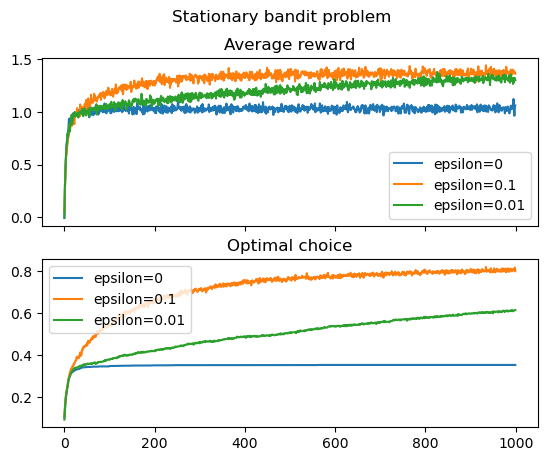

In [58]:
avg_rewards_eps0, avg_optimal_choice_eps0 = get_averages(bandit_pairs_eps0)
avg_rewards_eps01, avg_optimal_choice_eps01 = get_averages(bandit_pairs_eps01)
avg_rewards_eps001, avg_optimal_choice_eps001 = get_averages(bandit_pairs_eps001)

fig, axes = plt.subplots(nrows=2)
axes[0].plot(avg_rewards_eps0, label='epsilon=0')
axes[0].plot(avg_rewards_eps01, label='epsilon=0.1')
axes[0].plot(avg_rewards_eps001, label='epsilon=0.01')
axes[0].set_title('Average reward')
axes[0].legend()
axes[0].set_xticklabels([])
axes[1].plot(avg_optimal_choice_eps0, label='epsilon=0')
axes[1].plot(avg_optimal_choice_eps01, label='epsilon=0.1')
axes[1].plot(avg_optimal_choice_eps001, label='epsilon=0.01')
axes[1].set_title('Optimal choice')
axes[1].legend()

fig.suptitle('Stationary bandit problem')


# None stationary problem

In [63]:
k = 10
bandit_pairs_eps0 = {str(pair_id):{'bandit_problem': BanditProblem(k), 'bandit_agent': BanditAgent(k, epsilon=0),
                'actions':[], 'rewards':[], 'optimal_choice': []}
                for pair_id in range(2000)}

bandit_pairs_eps01 = {str(pair_id):{'bandit_problem': BanditProblem(k), 'bandit_agent': BanditAgent(k, epsilon=0.1),
                'actions':[], 'rewards':[], 'optimal_choice': []}
                for pair_id in range(2000)}

bandit_pairs_eps001 = {str(pair_id):{'bandit_problem': BanditProblem(k), 'bandit_agent': BanditAgent(k, epsilon=0.01),
                        'actions':[], 'rewards':[], 'optimal_choice': []}
                        for pair_id in range(2000)}

n_steps = 1000

for i in tqdm.tqdm(range(n_steps)):
    perform_strategy(bandit_pairs_eps0, update=True)
    perform_strategy(bandit_pairs_eps01, update=True)
    perform_strategy(bandit_pairs_eps001, update=True)
    


100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]


Text(0.5, 0.98, 'None Stationary bandit problem')

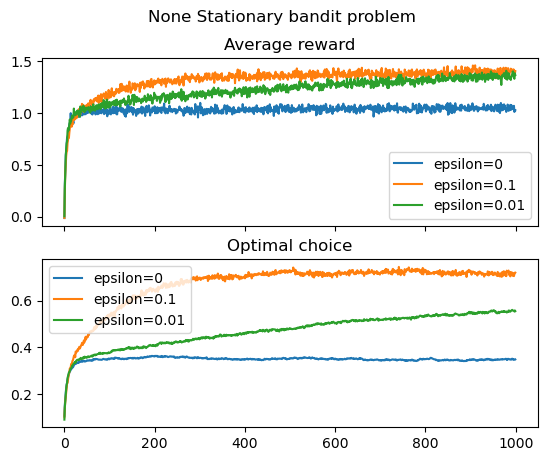

In [64]:
avg_rewards_eps0, avg_optimal_choice_eps0 = get_averages(bandit_pairs_eps0)
avg_rewards_eps01, avg_optimal_choice_eps01 = get_averages(bandit_pairs_eps01)
avg_rewards_eps001, avg_optimal_choice_eps001 = get_averages(bandit_pairs_eps001)

fig, axes = plt.subplots(nrows=2)
axes[0].plot(avg_rewards_eps0, label='epsilon=0')
axes[0].plot(avg_rewards_eps01, label='epsilon=0.1')
axes[0].plot(avg_rewards_eps001, label='epsilon=0.01')
axes[0].set_title('Average reward')
axes[0].legend()
axes[0].set_xticklabels([])
axes[1].plot(avg_optimal_choice_eps0, label='epsilon=0')
axes[1].plot(avg_optimal_choice_eps01, label='epsilon=0.1')
axes[1].plot(avg_optimal_choice_eps001, label='epsilon=0.01')
axes[1].set_title('Optimal choice')
axes[1].legend()

fig.suptitle('None Stationary bandit problem')


# exc 2.5 solution

In [67]:
k = 10

bandit_pairs_sample_average = {str(pair_id):{'bandit_problem': BanditProblem(k), 'bandit_agent': BanditAgent(k, epsilon=0.1),
                'actions':[], 'rewards':[], 'optimal_choice': []}
                for pair_id in range(2000)}

bandit_pairs_alpha = {str(pair_id):{'bandit_problem': BanditProblem(k), 'bandit_agent': BanditAgent(k, alpha = 0.1, epsilon=0.1),
                'actions':[], 'rewards':[], 'optimal_choice': []}
                for pair_id in range(2000)}


n_steps = 5000

for i in tqdm.tqdm(range(n_steps)):
    perform_strategy(bandit_pairs_sample_average, update=True)
    perform_strategy(bandit_pairs_alpha, update=True)

  0%|          | 20/5000 [00:01<06:34, 12.61it/s]

100%|██████████| 5000/5000 [07:00<00:00, 11.90it/s]


Text(0.5, 0.98, 'None Stationary, sample average vs constant step size')

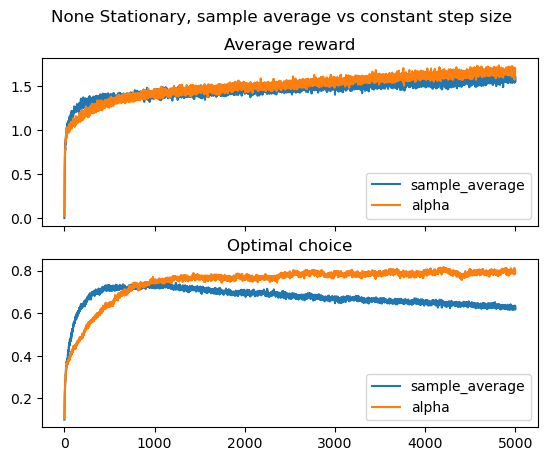

In [68]:
avg_rewards_sample_average, avg_optimal_choice_sample_average = get_averages(bandit_pairs_sample_average)
avg_rewards_alpha, avg_optimal_choice_alpha = get_averages(bandit_pairs_alpha)

fig, axes = plt.subplots(nrows=2)
axes[0].plot(avg_rewards_sample_average, label='sample_average')
axes[0].plot(avg_rewards_alpha, label='alpha')
axes[0].set_title('Average reward')
axes[0].legend()
axes[0].set_xticklabels([])

axes[1].plot(avg_optimal_choice_sample_average, label='sample_average')
axes[1].plot(avg_optimal_choice_alpha, label='alpha')
axes[1].set_title('Optimal choice')
axes[1].legend()

fig.suptitle('None Stationary, sample average vs constant step size')
